<a href="https://colab.research.google.com/github/MHendriF/Image-Classification/blob/main/RockPaperScissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Profile
---
Nama: Muhamad Hendri Febriansyah

Email: hendrifebriansyah28@gmail.com

Domisili: Mataram, Nusa Tenggara Barat

---

In [214]:
# Mengimpor library yang diperlukan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt
import zipfile
import os
import time
import shutil

In [215]:
# Verifikasi GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [216]:
# Memeriksa apakah file rockpaperscissors.zip ada di local jika tidak ada maka download file
local_zip = '/tmp/rockpaperscissors.zip'
if not os.path.exists(local_zip):
    !wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
 -O /tmp/rockpaperscissors.zip

In [217]:
# Menghapus dataset lama jika ada
old_dataset_dir = '/tmp/rockpaperscissors/rps-cv-images'
if os.path.exists(old_dataset_dir):
    shutil.rmtree(old_dataset_dir)

In [218]:
# Mengekstrak dataset baru
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/tmp')
    zip_ref.close()

dataset_dir = "/tmp/rockpaperscissors/rps-cv-images"

In [219]:
# Periksa apakah direktori rps-cv-images ada
if not os.path.exists(dataset_dir):
    raise FileNotFoundError("Direktori '/tmp/rockpaperscissors/rps-cv-images' tidak ditemukan setelah ekstraksi.")

In [220]:
# ImageDataGenerator untuk augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.4
)

In [221]:
# Memuat data latihan
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 1314 images belonging to 3 classes.


In [222]:
# Memuat dan validasi
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 874 images belonging to 3 classes.


In [223]:
# Membangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [224]:
# Kompilasi model dengan optimizer RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [225]:
# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

def lr_scheduler(epoch, lr):
    if epoch > 5:
        return lr * 0.9
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

In [226]:
# Mengukur waktu pelatihan
start_time = time.time()

In [227]:
# Melatih model dengan menggunakan GPU
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=20,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler_callback, reduce_lr],
        verbose=1
    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.4422 - loss: 1.4067 - val_accuracy: 0.4884 - val_loss: 1.1543 - learning_rate: 0.0010
Epoch 2/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4375 - loss: 1.3611

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4375 - loss: 1.3611 - val_accuracy: 0.6000 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 408ms/step - accuracy: 0.7079 - loss: 0.7488 - val_accuracy: 0.5995 - val_loss: 0.9083 - learning_rate: 0.0010
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.7466 - val_accuracy: 0.6000 - val_loss: 0.9465 - learning_rate: 0.0010
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accuracy: 0.8384 - loss: 0.4651 - val_accuracy: 0.3623 - val_loss: 1.3391 - learning_rate: 0.0010
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9688 - loss: 0.1680 - val_accuracy: 0.8000 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 394ms/step - accuracy: 0.8716 - loss: 0.3649 - val_accuracy: 0.6713 - val_loss: 0.6535 - learning_rate: 9.0000e-04
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.3869 - val_accurac

In [228]:
# Menghitung total waktu pelatihan dan rata-rata waktu per epoch
total_training_time = time.time() - start_time
average_time_per_epoch = total_training_time / len(history.history['accuracy'])

In [229]:
# Menampilkan informasi waktu pelatihan
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {average_time_per_epoch:.2f} seconds")

Total training time: 286.89 seconds
Average time per epoch: 15.10 seconds


In [230]:
# Menampilkan akurasi pelatihan dan validasi
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
print(f"Training accuracy: {training_accuracy:.4f}")
print(f"Validation accuracy: {validation_accuracy:.4f}")

Training accuracy: 0.9610
Validation accuracy: 0.9560


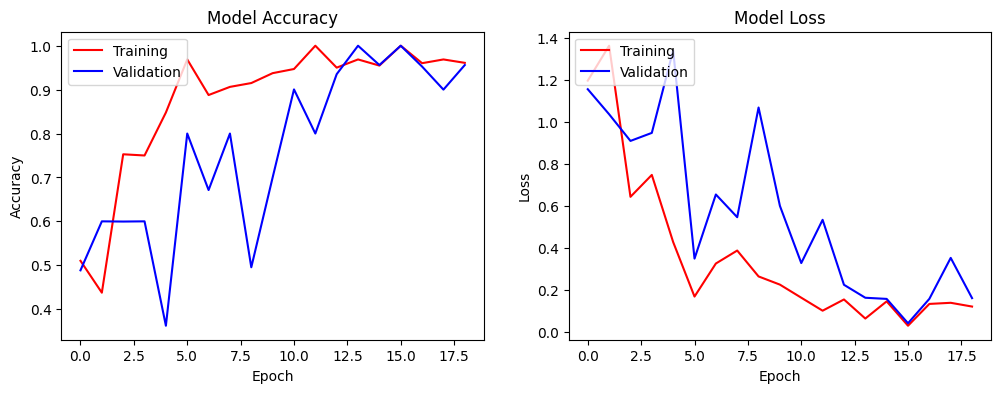

In [231]:
# Plot akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [232]:
# Menyimpan model terbaik
model.save('rock_paper_scissors_model.keras')

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


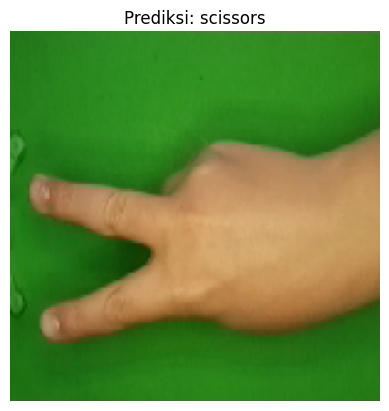

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


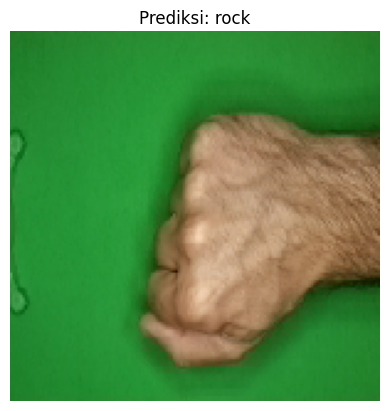

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


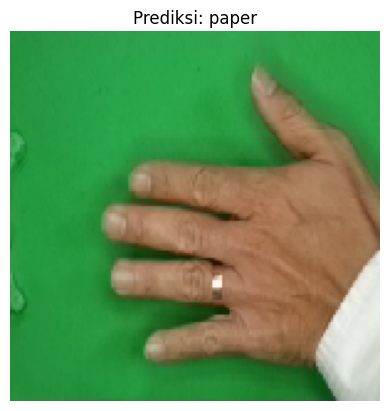

In [233]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Memuat model yang telah dilatih
model = tf.keras.models.load_model('rock_paper_scissors_model.keras')

# Fungsi untuk memprediksi gambar
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    prediction = model.predict(img_array)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_indices[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_class}')
    plt.axis('off')
    plt.show()

# Fungsi untuk menangani unggahan gambar
def on_upload_change(change):
    for name, file_info in change['new'].items():
        img_path = f'uploaded_image_{name}.jpg'
        with open(img_path, 'wb') as f:
            f.write(file_info['content'])
        predict_image(img_path)

# Membuat widget untuk unggahan gambar
upload_widget = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

# Menghubungkan widget dengan fungsi penanganan unggahan
upload_widget.observe(on_upload_change, names='value')

# Menampilkan widget
display(upload_widget)